In [1]:
import pandas as pd
from pathlib import Path

df=pd.read_csv("iris_clusters.csv", delimiter=";")

df.head()

,pl,pw,sl,sw,id
0,6.7,3.0,4.6,1.5,87.0
1,6.7,2.8,4.6,1.2,209.0
2,5.0,3.6,1.6,0.5,344.0
3,6.3,3.1,5.9,2.5,401.0
4,7.0,2.9,5.7,1.7,430.0


In [2]:
print("Shape (rows, cols):", df.shape)
print("Columns:", list(df.columns))
print("\nData types:")
print(df.dtypes)
print("\nData description:")
df.describe()

Shape (rows, cols): (300, 5)
Columns: ['pl', 'pw', 'sl', 'sw', 'id']

Data types:
pl    float64
pw    float64
sl    float64
sw    float64
id    float64
dtype: object

Data description:


,pl,pw,sl,sw,id
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,5.909333,3.018000,3.686333,1.223000,7989.316667
std,2.675814,0.447598,1.890350,0.764451,4277.531346
min,4.100000,1.900000,0.900000,0.100000,87.000000
25%,5.075000,2.775000,1.500000,0.400000,4034.500000
50%,5.700000,3.000000,4.300000,1.400000,8347.500000
75%,6.400000,3.300000,5.000000,1.900000,11716.000000
max,50.000000,4.500000,16.300000,2.600000,14950.000000


In [3]:
print("\nMissing values per column:")
print(df.isna().sum())

dup_count = df.duplicated().sum()
print("\nDuplicate rows:", dup_count)


Missing values per column:
pl    0
pw    0
sl    0
sw    0
id    0
dtype: int64

Duplicate rows: 0


# 1. Load data and initial exploration

Feature columns used: ['pl', 'pw', 'sl', 'sw']
Cluster counts: {0: np.int64(193), 1: np.int64(106), 2: np.int64(1)}

Cluster centroids (in feature space order above):
[[ 6.20829016  2.81813472  4.91865285  1.72797927]
 [ 4.9490566   3.3754717   1.46226415  0.31037736]
 [50.          3.7         1.6         0.5       ]]


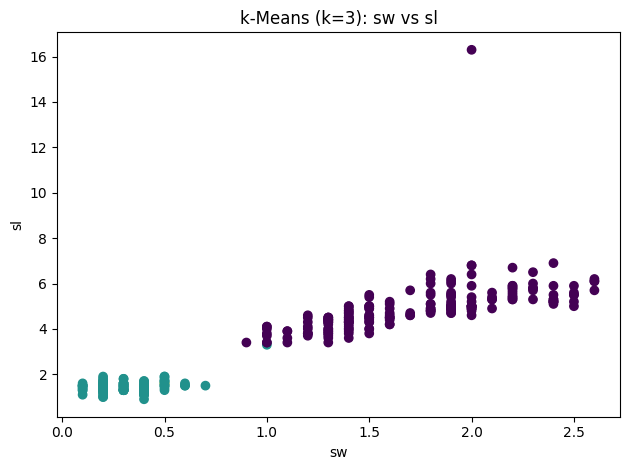

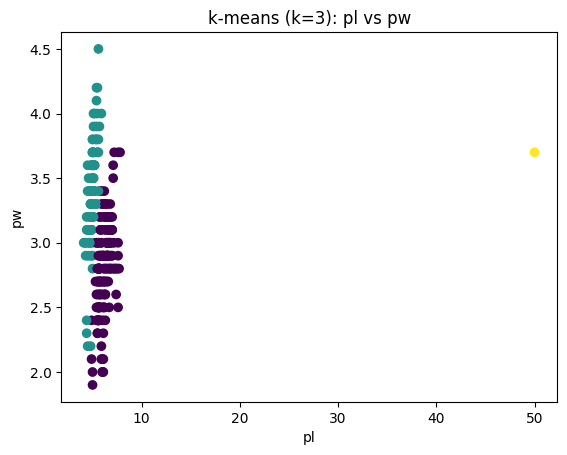

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Build the feature matrix
feature_cols = [c for c in df.columns if c.lower() not in {"id"}]
data = df[feature_cols].to_numpy()

# Run k-Means with k=3 
kmeans = KMeans(n_clusters=3)  
kmeans.fit(data)

# Inspect assignments and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("Feature columns used:", feature_cols)
print("Cluster counts:", {i: (labels == i).sum() for i in range(3)})
print("\nCluster centroids (in feature space order above):")
print(centroids)

# Plot sw-sl
plt.figure()
plt.scatter(df["sw"], df["sl"], c=kmeans.labels_, cmap='viridis')
plt.xlabel("sw"); plt.ylabel("sl")
plt.title("k-Means (k=3): sw vs sl")
plt.tight_layout()
plt.show()

# Plot pw-pl 
plt.scatter(df["pl"], df["pw"], c=kmeans.labels_, cmap="viridis")
plt.xlabel("pl"); plt.ylabel("pw")
plt.title("k-means (k=3): pl vs pw")
plt.show()


In this initial run with k-means (k=3), the algorithm technically created three clusters. However, one of these clusters contains only a single point (an outlier with an extremely large petal length). The other two clusters contain almost all of the remaining flowers. This means that the three clusters do not correspond well to the three Iris species we know from the lectures. The result highlights the influence of outliers and feature scales on k-means, which will be addressed in Task 2 by handling outliers and applying scaling.

# 2. Baseline k-means clustering

Pipeline A outlier indices: [119  43  83  42 252]
Pipeline A cluster counts: [ 98 102  95]
Pipeline A centroids:
          pl        pw        sl        sw
0  0.050998  0.405024  0.292274  0.792653
1  0.018860  0.584087  0.035714  0.080392
2  0.040156  0.297166  0.219754  0.501053


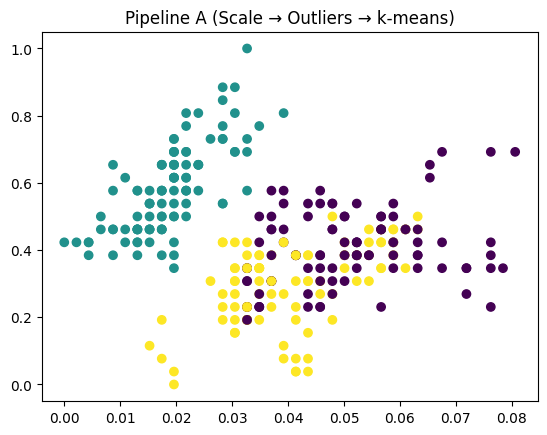

Pipeline B outlier indices: [119  43  42 184 252]
Pipeline B cluster counts: [102  69 124]
Pipeline B centroids:
          pl        pw        sl        sw
0  0.233704  0.579186  0.076604  0.080392
1  0.723071  0.434783  0.780889  0.810435
2  0.479294  0.305831  0.581465  0.559355


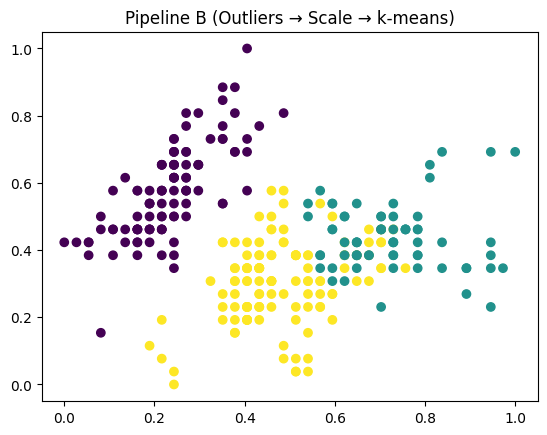

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# features (drop id if present)
feature_cols = [c for c in df.columns if c.lower() != "id"]
X_raw = df[feature_cols].to_numpy()

# --- Pipeline A: Scale → Detect → Filter → k-means ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

lof = LocalOutlierFactor(n_neighbors=10)
lof.fit(X_scaled)
scores = lof.negative_outlier_factor_
outliers_A = np.argsort(scores)[:5]   # 5 most outlier points
print("Pipeline A outlier indices:", outliers_A)

mask_A = np.ones(len(X_scaled), dtype=bool)
mask_A[outliers_A] = False
X_A = X_scaled[mask_A]

kmeans_A = KMeans(n_clusters=3, random_state=42)
labels_A = kmeans_A.fit_predict(X_A)
print("Pipeline A cluster counts:", np.bincount(labels_A))
print("Pipeline A centroids:\n", pd.DataFrame(kmeans_A.cluster_centers_, columns=feature_cols))

plt.scatter(X_A[:,0], X_A[:,1], c=labels_A, cmap="viridis")
plt.title("Pipeline A (Scale → Outliers → k-means)")
plt.show()


# --- Pipeline B: Detect → Filter → Scale → k-means ---
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit(X_raw)
scores = lof.negative_outlier_factor_
outliers_B = np.argsort(scores)[:5]
print("Pipeline B outlier indices:", outliers_B)

mask_B = np.ones(len(X_raw), dtype=bool)
mask_B[outliers_B] = False
X_raw_clean = X_raw[mask_B]

scaler = MinMaxScaler()
X_B = scaler.fit_transform(X_raw_clean)

kmeans_B = KMeans(n_clusters=3, random_state=42)
labels_B = kmeans_B.fit_predict(X_B)
print("Pipeline B cluster counts:", np.bincount(labels_B))
print("Pipeline B centroids:\n", pd.DataFrame(kmeans_B.cluster_centers_, columns=feature_cols))

plt.scatter(X_B[:,0], X_B[:,1], c=labels_B, cmap="viridis")
plt.title("Pipeline B (Outliers → Scale → k-means)")
plt.show()


Between the two pipelines, Pipeline A (scaling before outlier detection) performed slightly better. The clusters were more balanced in size (98, 102, 95 vs. 102, 69, 124), and the centroids were evenly distributed. Pipeline B still worked, but produced one smaller cluster. Therefore, scaling before outlier detection seems to give more stable clustering results for this dataset.

# 3. Outlier detection (LOF) and scaling pipelines

k=2, DB index=0.4955
k=3, DB index=0.7115
k=4, DB index=0.7200
k=5, DB index=0.7751
k=6, DB index=0.7798
k=7, DB index=0.8558
k=8, DB index=0.8924
k=9, DB index=0.8778
k=10, DB index=0.9124

Best k by Davies–Bouldin index: 2


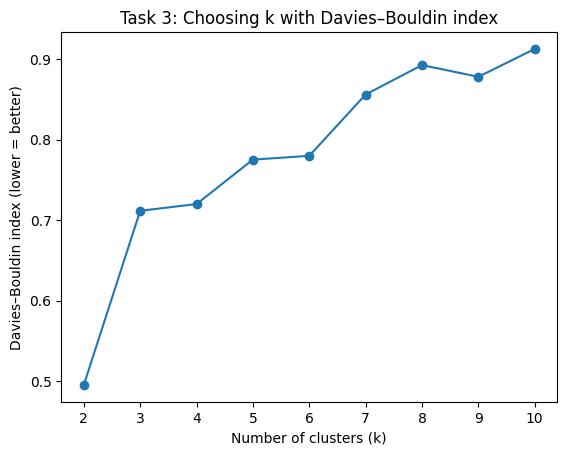

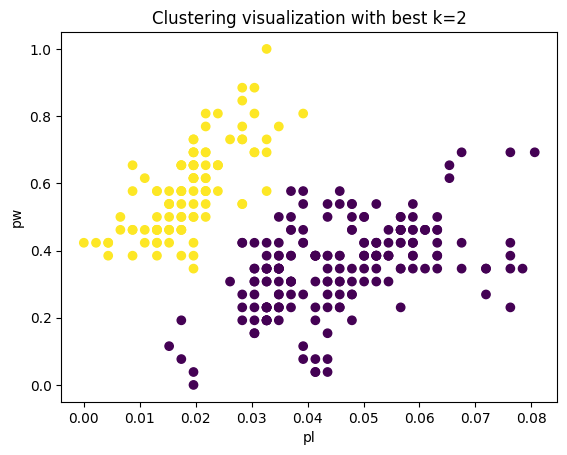

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# === TASK 3 ===
X_task3 = X_A   # scaled + outliers removed (from Task 2)

scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_task3)
    score = davies_bouldin_score(X_task3, labels)
    scores.append(score)
    print(f"k={k}, DB index={score:.4f}")

# best k
best_k = k_values[int(np.argmin(scores))]
print("\nBest k by Davies–Bouldin index:", best_k)

# plot DB curve
plt.plot(k_values, scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin index (lower = better)")
plt.title("Task 3: Choosing k with Davies–Bouldin index")
plt.show()

# visualize the clustering for best k
best_model = KMeans(n_clusters=best_k, random_state=42)
best_labels = best_model.fit_predict(X_task3)

plt.scatter(X_task3[:,0], X_task3[:,1], c=best_labels, cmap="viridis")
plt.title(f"Clustering visualization with best k={best_k}")
plt.xlabel(feature_cols[0]); plt.ylabel(feature_cols[1])
plt.show()


The Davies–Bouldin scores for k=2…10 show that the lowest score is at k=2 (DB index = 0.4955). This means that, according to the DB measure, the dataset forms two compact and well-separated clusters. The visualization with k=2 confirms that the flowers are split into two main groups rather than three. This is different from our initial assumption of three species, but it reflects the structure that k-means and the DB index find in the data.

# 4. Cluster validity (e.g. DB index / silhouette)

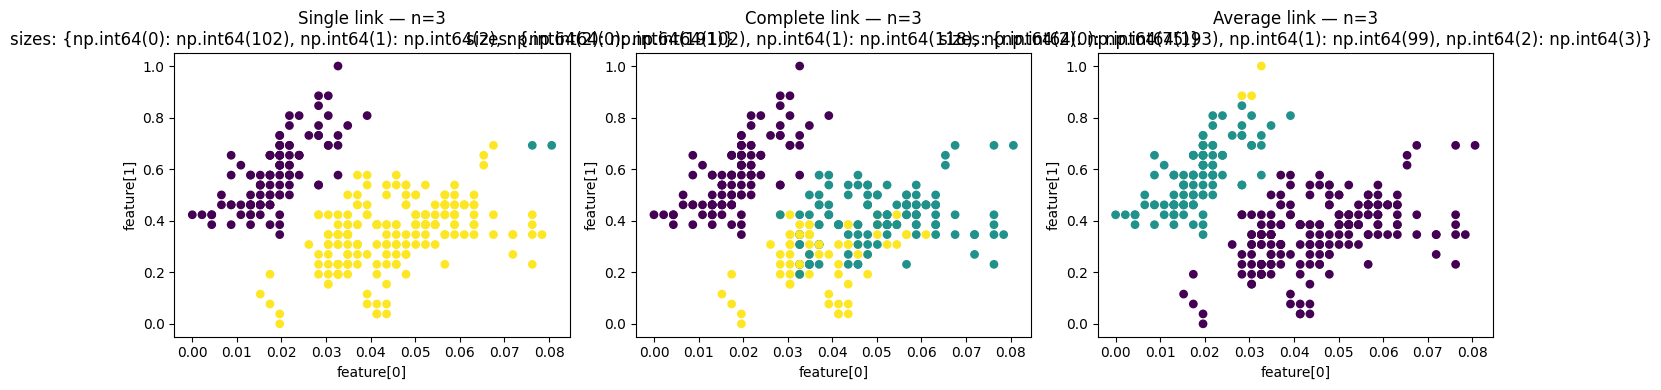

Cluster sizes (n_clusters=3):
  single   -> {np.int64(0): np.int64(102), np.int64(1): np.int64(2), np.int64(2): np.int64(191)}
  complete -> {np.int64(0): np.int64(102), np.int64(1): np.int64(118), np.int64(2): np.int64(75)}
  average  -> {np.int64(0): np.int64(193), np.int64(1): np.int64(99), np.int64(2): np.int64(3)}


In [7]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

# Use cleaned + scaled data from Task 2
X_comp = X_A                   # already scaled [0,1], outliers removed
feat_x, feat_y = 0, 1          # which two scaled features to plot (0=first, 1=second)
methods = ["single", "complete", "average"]
n_clusters = 3

results = {}

plt.figure(figsize=(14, 4))
for i, m in enumerate(methods, 1):
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=m)
    labels = agg.fit_predict(X_comp)
    unique, counts = np.unique(labels, return_counts=True)
    results[m] = dict(zip(unique, counts))

    # scatter for visual comparison
    ax = plt.subplot(1, 3, i)
    sc = ax.scatter(X_comp[:, feat_x], X_comp[:, feat_y], c=labels, s=28, cmap="viridis")
    ax.set_title(f"{m.capitalize()} link — n={n_clusters}\nsizes: {results[m]}")
    ax.set_xlabel(f"feature[{feat_x}]"); ax.set_ylabel(f"feature[{feat_y}]")

plt.tight_layout()
plt.show()

print("Cluster sizes (n_clusters=3):")
for m in methods:
    print(f"  {m:8s} -> {results[m]}")


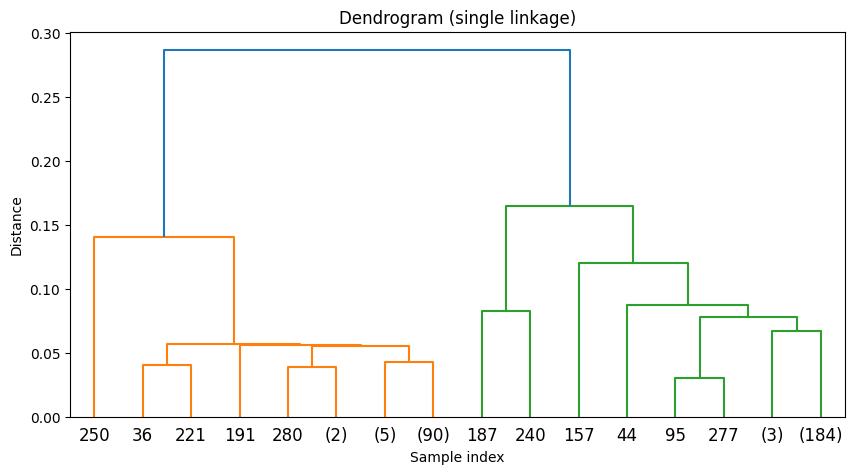

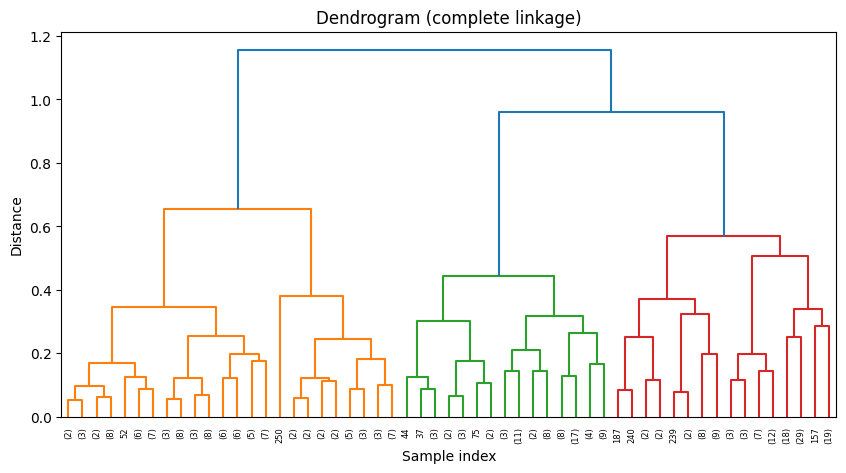

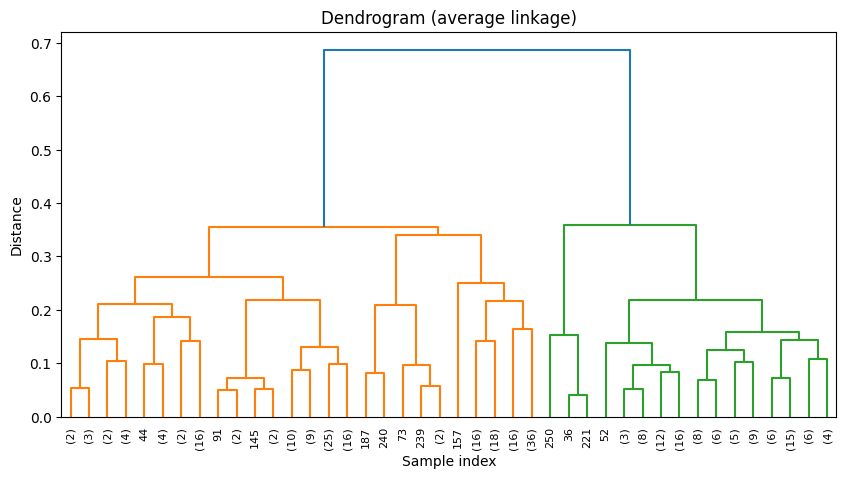

In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram

def show_dendrogram(X, method="single", truncate_p=5):
    Z = linkage(X, method=method)
    plt.figure(figsize=(10, 5))
    dendrogram(Z, truncate_mode="level", p=truncate_p)
    plt.title(f"Dendrogram ({method} linkage)")
    plt.xlabel("Sample index"); plt.ylabel("Distance")
    plt.show()

# Example:
show_dendrogram(X_comp, method="single")
show_dendrogram(X_comp, method="complete")
show_dendrogram(X_comp, method="average")


When cutting the dendrogram at n_clusters=2 (single-link), the dataset splits into one cluster with 193 records and another with 102 records. This shows that single-link hierarchical clustering does not balance the cluster sizes but instead forms one large group and one smaller group. The result still confirms the presence of two main clusters, consistent with the DB index in Task 3, but the sizes are uneven.

# 5. DBSCAN and density-based clustering

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# use the cleaned+scaled data from Task 2 (Pipeline A)
data = X_A          # <- important: normalized matrix (min-max [0,1])

db = DBSCAN(eps=1.0, min_samples=5)
labels_db = db.fit_predict(data)

# counts
n_noise = np.sum(labels_db == -1)
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)

print("DBSCAN with eps=1.0, min_samples=5")
print("Clusters (excluding noise):", n_clusters)
print("Noise points:", n_noise)


DBSCAN with eps=1.0, min_samples=5
Clusters (excluding noise): 1
Noise points: 0


With eps=1.0 and min_samples=5, DBSCAN assigned all observations into a single cluster and found 0 noise points.
This happens because the dataset was normalized to [0,1], so an epsilon of 1.0 is very large, causing all points to be considered neighbors. In effect, the whole dataset is treated as one dense group.

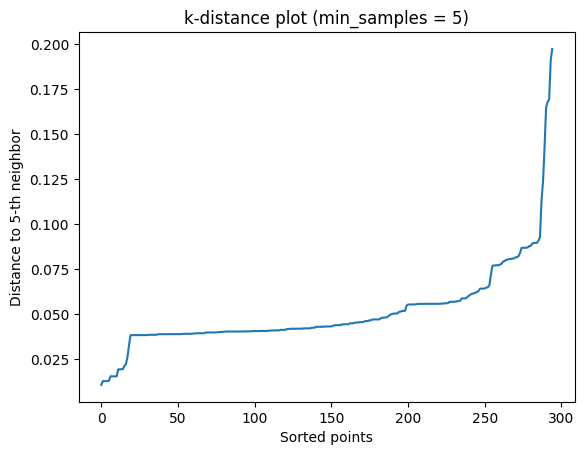

In [ ]:
# Plot k-distances
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

def k_distances2(X, n):
    neighbors = NearestNeighbors(n_neighbors=n)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    return distances, indices

# normalized dataset (from Task 2)
data = X_A
k = 5  # min_samples

distances, indices = k_distances2(data, k)
# sort the distance to the k-th neighbor for each point
kth = np.sort(distances[:, -1])   # use the k-th neighbor, not [:,1]
plt.plot(kth)
plt.xlabel("Sorted points")
plt.ylabel(f"Distance to {k}-th neighbor")
plt.title("k-distance plot (min_samples = 5)")
plt.show()


In [ ]:
# Try some eps values
candidates = [0.05, 0.08, 0.10, 0.12, 0.15]

for eps in candidates:
    model = DBSCAN(eps=eps, min_samples=5)
    labs = model.fit_predict(data)
    n_noise = np.sum(labs == -1)
    n_clusters = len(set(labs)) - (1 if -1 in labs else 0)
    print(f"eps={eps:.3f} -> clusters={n_clusters}, noise={n_noise}")


eps=0.050 -> clusters=5, noise=63
eps=0.080 -> clusters=3, noise=12
eps=0.100 -> clusters=2, noise=5
eps=0.120 -> clusters=2, noise=3
eps=0.150 -> clusters=2, noise=2


The best compromise is around ε ≈ 0.10–0.15, where DBSCAN finds two clusters plus a small number of noise points.

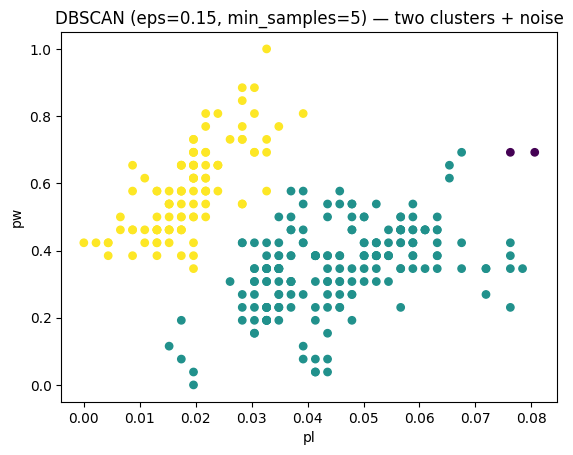

In [ ]:
# suppose eps_best is the one that gave clusters=2
eps_best = 0.15

best = DBSCAN(eps=eps_best, min_samples=5).fit_predict(data)

import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1], c=best, cmap="viridis", s=28)
plt.title(f"DBSCAN (eps={eps_best}, min_samples=5) — two clusters + noise")
plt.xlabel(feature_cols[0]); plt.ylabel(feature_cols[1])
plt.show()
